# GRO620 - Problématique

**Simon Chamorro et Samuel Hovington**

Dans ce document, nous présenterons la problématique de l'APP 6 - Vision par ordinateur de la S6 en Génie Robotique à l'Université de Sherbrooke ainsi que notre résolution.

# Identification du problème

# Procédure de résolution

# Mise en oeuvre du pipeline

Dans cette section, nous présenterons notre code qui résout le problème et décrirons l'implémentation au travers d'explications et de commentaires dans le code. Les lignes qui suivent importent les librairies nécessaires pour résoudre la problématique.

In [2]:
# Imports 

import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
import os

# Check opencv version

print("GRO620 - Problématique")
print("OpenCV version", cv2.__version__)

%matplotlib inline


GRO620 - Problématique
OpenCV version 4.2.0


##  Chargement des images 

D'abord, on charge les images fournies et on en affiche une à l'écran afin de visualiser le problème.

In [3]:
# Check if images are in dir

images_fn = os.listdir("photos_prob/")
print("%i photo(s) à traiter"%(len(images_fn)))
if (len(images_fn) == 0):
    print("ERREUR! Vérifiez que vous avez bien un dossier photos_prob au même endroit que ce calepin.")
    
images = []

# Load images

for idx, f in enumerate(images_fn):
    img = {"id" : idx}
    img['name'] = f.split('.')[0]
    img['bgr'] = cv2.imread(os.path.join("photos_prob/", f))
    images.append(img)

9 photo(s) à traiter


Les images sont stockées dans une liste. Chaque image est un dictionnaire python qui contient plusieurs informations comme le nom de la photo, une version BGR de la photo, et dans lequel on stockera les différentes versions et informations qui seront récoltées tout au long du processus. La première étape sera de transformée les images BGR en RGB et en tons de gris. Ces versions seront nécessaires pour le traitement et pour la visualisation.

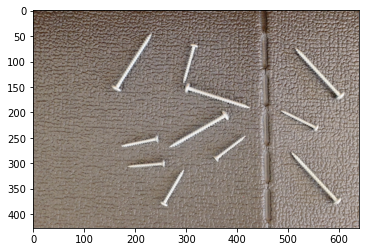

In [4]:
for img in images:
    img['rgb'] = cv2.cvtColor(img['bgr'], cv2.COLOR_BGR2RGB)
    img['gray'] = cv2.cvtColor(img['bgr'], cv2.COLOR_BGR2GRAY)
plt.imshow(images[0]['rgb'])

##  Paramètres de la caméra

Ensuite, nous calculons les paramètres intrinsèques et extrinsèques de la caméra, qui seront nécessaires plus tard.

Pour ce qui est des paramètres intrinsèques, la longueur focale ainsi que la taille du capteur sont fournies. On a sa résolution, ce qui nous permet de trouver la taille des pixels en mm et de définir la matrice K.


In [6]:
# Intrinsic camera params

f_len = 23                 # mm
px_size = 23.4/640         # mm/px
f_len_px = f_len/px_size   # px
W = 640                    # px
H = 427                    # px

K = np.array([[f_len_px,       0., W/2],
              [      0., f_len_px, H/2],
              [      0.,       0.,  1.]
])

Pour ce qui est des paramètres extrinsèques, la matrice de transformation Tc est fournie.

In [7]:
# Extrinsic params

Tc = np.array([[0., 1.,  0., 500],  # mm
               [1., 0.,  0., 200],
               [0., 0., -1., 282],
               [0., 0.,  0.,  1.]  
])

d = 1/282

## Isoler les pixels

D'abord, afin d'isoler les pixels appartenant aux vis, nous devons utiliser les images en noir et blanc. Cela nous facilitera la tâche lorsque nous devrons déterminer les contours de celles-ci.

On construit un histogramme des valeurs de gris de l'image pour analyser sa composition.

(0.0, 256.0)

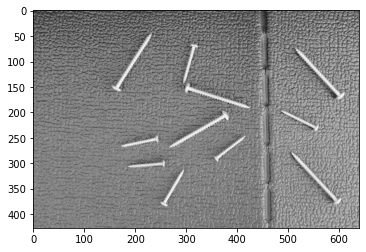

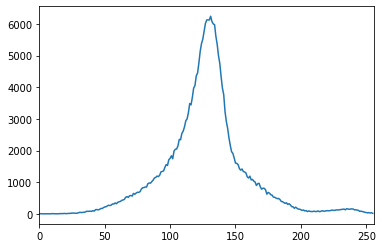

In [8]:
hist = cv2.calcHist([images[0]['gray']], [0], None, [256], [0,256])

plt.figure()
plt.imshow(images[0]['gray'], cmap='gray')

plt.figure()
plt.plot(hist)
plt.xlim([0,256])


En regardant une des images en noir et blanc, on voit que les vis sont très pâles comparativement au reste de l'image. On peut donc utiliser un *threshold* afin d'éliminer le fond et accentuer le contour des vis. L'histogramme nous montre que la couleur des vis se trouve entre 200 et 255, tout le reste du spectre correspond au convoyeur.

Par contre, une fois que l'image est binaire, on voit que certaines vis perdent des morceaux, ce qui rend les contours discontinus. On applique donc un filtre Gaussien pour adoucir l'image.

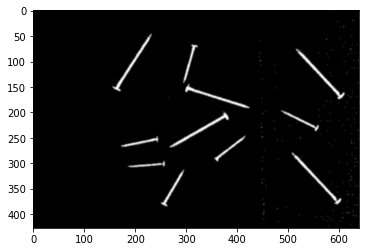

In [9]:
for img in images:
    
    # Threshold and bluring
    ret, thresh = cv2.threshold(img['gray'], 200, 255, cv2.THRESH_BINARY)
    img['blur'] = cv2.GaussianBlur(thresh, (5, 5), 0)

plt.imshow(images[0]['blur'], cmap='gray')

Une fois que l'image est binaire et filtrée, il reste tout de même quelques tâches blanches, qui ne correspondent pas à des vis. Pour les enlever, on applique une érosion suivie d'une dilatation. Cela a pour effet d'enlever les tâches blanches de petite taille. Pour ce qui est des vis, celles-ci perdent dertains pixels durant l'érosion, mais les regagnent pour retrouver leur taille durant la dilatation. Durant cette étape, on perd un peu de détail sur les contours, mais ce n'est pas très important puisqu'on s'intéresse principalement au barycentre des vis, à leur orientation et à leur longueur.

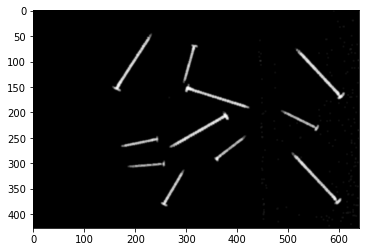

In [10]:
for img in images:

    # Erosion and dilation to remove small white spots
    kernel = np.ones((3,3), np.uint8)  
    img_erosion = cv2.erode(img['blur'], kernel, iterations=1) 
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)
    img['bw'] = img_dilation

plt.imshow(images[0]['bw'], cmap='gray')

Une fois que ces images ont été traitées, les contours peuvent être détectés en utilisant la fonction *findContours* de *opencv*. Ici, deux étapes importantes sont réalisées.

Premièrement, pour chaque contour trouvé, l'aire est calculée. Si celle-ci est inférieure à 200, le contour n'est pas pris en compte, c'est bien trop petit pour qu'il s'agisse d'une vis. Bien que cette valeur soit *hardcoded*, c'est seulement pour filtrer le bruit restant qui est très petit. Cela ne devrait donc pas causer de problème.

Deuxièmement, une vérification est faite pour détecter les vis qui sont partiellement détectées. Celles-ci sont également ignorées puisqu'on assume qu'elles seront détectées de manière complète dans un prochain *frame*.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa9701d4cd0>,
 <matplotlib.image.AxesImage at 0x7fa97016f0d0>)

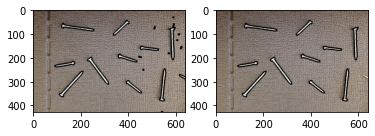

In [11]:
for img in images:
    
    # Find contours
    contours, hierarchy = cv2.findContours(img['bw'], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    screw_cnt = []
    for c in contours:
        
        # Filter by area
        area = cv2.contourArea(c)
        if area < 200:
            continue
        
        # Filter partial detections
        partial = False
        tol = 3
        for p in c:
            if p[0][0] < tol or p[0][0] > W-1-tol or p[0][1] < tol or p[0][1] == H-1-tol:
                partial = True 
        
        if not partial:
            screw_cnt.append(c)
            
    # Add contour to image and save in dict
    img['cnt'] = cv2.drawContours(img['rgb'].copy(), screw_cnt, -1, (0,0,0), 3)
    img['screw_cnt'] = screw_cnt

# Plot filtered vs unfiltered
img_bad = cv2.drawContours(images[-1]['rgb'].copy(), contours, -1, (0,0,0), 3)
plt.subplot(121),plt.imshow(img_bad)
plt.subplot(122),plt.imshow(images[-1]['cnt'])


Voici le résultat de la détection des contours.

## Trouver les informations des vis dans le repère C

Une fois que les contours de chaque vis sont identifiés, il reste à trouver les paramètres de chacune de ces vis, soient le barycentre, l'angle et le type de vis selon sa longueur (courte ou longue).

- **Barycentre :** Afin de trouver le barycentre, la fonction de *opencv* *moments* est utilisée. Celle-ci nous retourne les moments à partir desquels on peut calculer le centre en x et en y.
- **Angle :** Pour trouver l'orientation de la vis, on fait une régression linéaire des points de la vis. On obtient donc le vecteur directeur de la droite, ce qui nous permet de calculer l'orientation.
- **Longueur :** Pour ce qui est de la longueur, on la calcule en utilisant la fonction *minEnclosingCircle*. Cette fonction trouve le cercle le plus petit qui englobe la vis. Le diamètre de ce cercle correspond donc à la longueur de la vis. Les vis sont ensuite classées selon la longueur obtenue(courtes et longues). 


In [12]:
# Find screws information
for img in images:

    img['detections'] = img['rgb'].copy()
    screws = []

    for idx, c in enumerate(img['screw_cnt']):

        # Center of contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # Find angle
        vx, vy, x, y = cv2.fitLine(c, cv2.DIST_L2,0,0.01,0.01)
        angle = np.arctan2(np.abs(vy), np.abs(vx))

        # Find lenght of screw
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        radius = int(radius)
        length = 2*radius*px_size
        screw_type = 'short' if length < 4 else 'long'
        # To draw circle
        # cv2.circle(img['detections'],center,radius,(0,255,0),2)

        # Draw on image
        cv2.drawContours(img['detections'], [c], -1, (0, 255, 0), 2)
        cv2.circle(img['detections'], (cX, cY), 7, (255, 0, 0), -1)
        cv2.putText(img['detections'], str(cX) + ", " + str(cY) + ", " + str(int(angle*180/np.pi)) + " deg", 
                    (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        screws.append({'id': idx,
                       'pixel_x': cX, 
                       'pixel_y': cY,
                       'len': length,
                       'angle': angle,
                       'type': screw_type})
    
    img['screws'] = screws


Voici les détections obtenues. On voit que toutes les vis sont détectées sauf celles qui sont partiellement hors du champs de vision. Aussi, il n'y a pas de faux positif.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa953767430>,
 <matplotlib.image.AxesImage at 0x7fa9536c0070>)

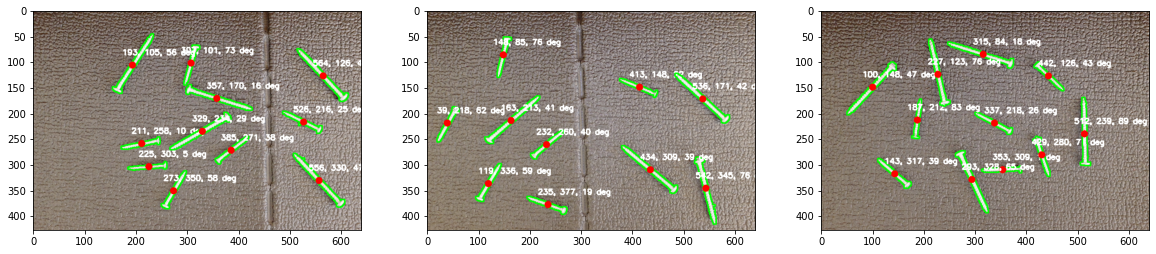

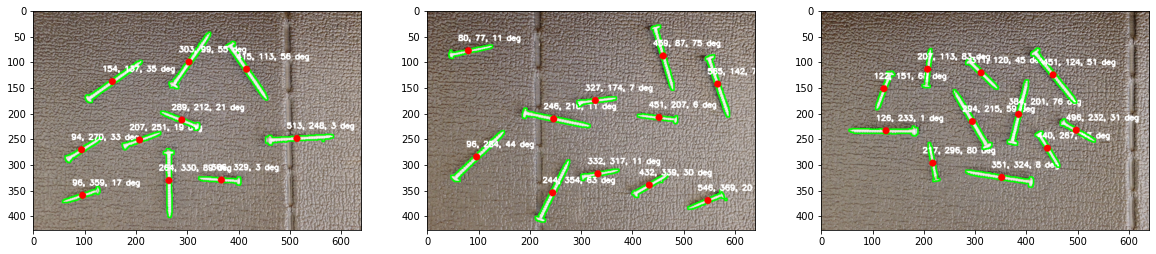

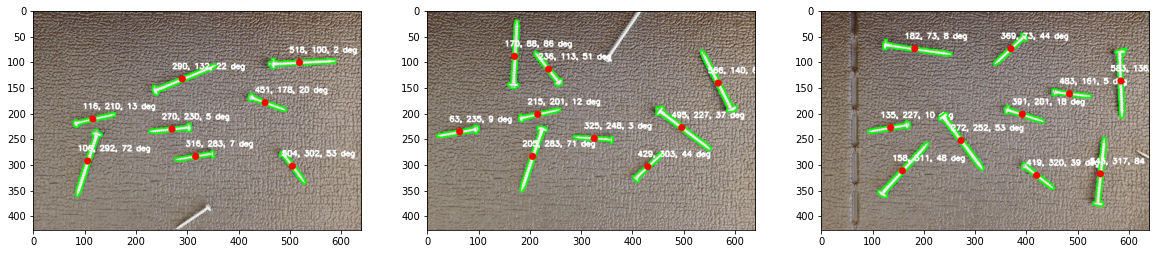

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(images[0]['detections'])
plt.subplot(132),plt.imshow(images[1]['detections'])
plt.subplot(133),plt.imshow(images[2]['detections'])

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(images[3]['detections'])
plt.subplot(132),plt.imshow(images[4]['detections'])
plt.subplot(133),plt.imshow(images[5]['detections'])

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(images[6]['detections'])
plt.subplot(132),plt.imshow(images[7]['detections'])
plt.subplot(133),plt.imshow(images[8]['detections'])

## Transformation vers le repère 0

Une fois que les coordonnées des vis sont obtenues, il faut les mettre dans le repère du convoyeur. Pour ce faire, on inverse la matrice de transformation fournie, puis on calcule les matrices Kt et Pt. De cette manière, on peut projetter chaque point dans le repère du convoyeur à partir des coordonnées en pixels.

In [14]:
# Transform pixel coordinates to 3D coordinates

# Find Projection matrix
T = np.linalg.inv(Tc)
Kt = np.zeros((4, 4))
Kt[0:3,0:3] = K
Kt[3,3] = 1

# Find P tilde and inverse
Pt = np.dot(Kt, T)
Pt_inv = np.linalg.inv(Pt)

for img in images:
    
    for screw in img['screws']:
        x = screw['pixel_x'] * px_size
        y = screw['pixel_y'] * px_size
        point_c = np.array([x, y, 1, d])
        point_0 = point_c / d
        point_0 = np.dot(Pt_inv, point_0)

        screw['coords'] = (point_0[0], point_0[1], 0)
        

## Production des rapports CSV

Pour finir, toutes les données calculées sont sauvegardées dans un tableau CSV pour chaque image selon le format demandé.

In [15]:
# Output CSV files

if not os.path.exists('csv'):
    os.makedirs('csv')
    
for img in images:
    with open('./csv/' + img['name'] + '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "Type", "X (m)", "Y (m)", "Z (m)", "Theta (rad)"])
        for screw in img['screws']:
            writer.writerow([screw['id'], screw['type'], "%.2f"%screw['coords'][0], 
                             "%.2f"%screw['coords'][1], "%.2f"%screw['coords'][2], 
                             "%.3f"%screw['angle']])

# Analyse des résultats

En conclusion, le pipeline développé répond aux critères de performance demandés. Comme on peut le voir à la section précédente sur toutes les images présentées, les vis sont bien détectées. Il n'y a aucun faux négatif. Toutes les vis qui se trouvent entièrement dans l'image sont trouvées, puis analysées. Il n'y a pas non plus de faux positifs, aucune fausse détection n'est faite dans les images.

Pour ce qui est de la précision, il n'y avait pas de critère spécifique quant à la tolérence d'erreur pour la position du barycentre des vis. Cependant, en examinant les images à l'oeil, la détection semble être assez précise. Cela serait suffisant pour un bras robotique chargé de faire le tri des vis en utilisant les coordonnées calculées.

**Points forts :**
- Robustesse : Notre pipeline est assez robuste. En effet, aucune des neuf photos analysées n'a de fausses détections. Un des points qui contribue à cette performance et la redondance du filtrage. En effet, dans la section où les pixels sont isolés, nous avons plusieurs étapes séquentielles qui servent à filtrer le bruit avant de détecter les contours. D'abord, il y a le *threshold* et le *blur*, suivis de l'érosion et de la dilatation. Finalement, si certains artéfacts démeurent, une dernière étape utilise l'aire des contours détectés pour les filtrer. Cela fait en sorte que même si une légère erreur persiste suite aux premières étapes du pipeline, elle sera filtrée par la suite.

**Points faibles :**
- Adaptation : Bien que notre pipeline soit assez robuste face aux différentes photos analysées, il demeure assez spécifique à la configuration de la caméra. Cela signifie que toute variation de position ou d'éclairage dans l'usine nécessiterait un ajustement des paramètres utilisés. L'étape de *threshold* dépend grandement de la luminosité de l'image et les étapes suivantes ont toutes des paramètres qui ont aussi été ajustés pour la configuration actuelle. De plus, le changement de repère est directement affecté par le positionnement de la caméra par rapport au convoyeur. 

Somme toute, les peformances sont suffisantes pour le scénario en question. Comme mentionné plus tôt, le système n'a aucun faux positif ni faux négatif. De plus, on peut assumer que les neuf photos analysées représentent assez bien toutes les conditions qui seront présentées au système. En effet, il s'agit d'une ligne de production où la caméra est fixe et les pièces qui circulent sur le convoyeur sont toujours les mêmes. Les conditions d'éclairage sont aussi constantes et très bien controlées. Il y a donc peu de facteurs qui pourraient introduire des erreurs. De plus, bien qu'une modification des paramètres (éclairage ou déplacement de la caméra) impliquerait un réajustement du système, l'ajustement serait assez simple à faire. En effet, le code fonctionnerait encore, il faudrait simplement réajuster les valeurs des paramètres utilisés.